In [1]:
# IMPORT DATA

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

The analysis demonstrates how to use machine learning, specifically deep learning with PyTorch, to model and predict phytoplankton concentration based on oceanographic variables, showcasing a non-linear relationship.

We are going to generate data with a non-linear relationship and add noise.

In [2]:
# generate synthetic data with a non-linear relationship
np.random.seed(1997)

num_samples = 10000

def generate_data(n):
    # # I encourage you to mess around with the values for these distributions or even try different distributions, for example a normal/gaussian?
    # sst = np.random.uniform(10, 30, n)  # sea surface temperature (°c)
    # nutrient_levels = np.random.uniform(0.5, 3.0, n)  # nutrient levels (arbitrary units)
    # sunlight_hours = np.random.uniform(8, 16, n)  # daily sunlight hours

    sst = np.random.normal(loc=25, scale=5, size=n)  # Normal distribution for sea surface temperature
    nutrient_levels = np.random.gamma(shape=2, scale=1, size=n)  # Gamma distribution for nutrient levels
    sunlight_hours = np.random.normal(loc=12, scale=2, size=n)

    # Ensure all data is within realistic bounds
    sst = np.clip(sst, 10, 40)  # Clip SST values to be within realistic range, e.g., 10°C to 30°C
    # nutrient_levels = np.clip(nutrient_levels, 0.5, 3.0)  # Clip nutrient levels to a reasonable range
    sunlight_hours = np.clip(sunlight_hours, 6, 16)

    # # non-linear relation: phytoplankton concentration (sinx, x, x)
    # phyto_concentration = (
    #     2.5 * sst + 
    #     10 * np.sin(0.3 * sst) + 
    #     6 * nutrient_levels + 
    #     (-3.5) * sunlight_hours + 
    #     np.random.normal(0, 3, n)
    # ) + 50

    # # non-linear relation: phytoplankton concentration (sinx, x^2, e^x), this works but coeffs could be better
    # phyto_concentration = (
    #     2.5 * sst + 
    #     10 * np.sin(0.3 * sst) + 
    #     6 * np.power((1/6**2) *nutrient_levels,2) + 
    #     (-3.5) * np.exp((1/np.exp(3.5))*sunlight_hours) + 
    #     np.random.normal(0, 3, n)
    # ) + 50

    # non-linear relation: phytoplankton concentration (sinx, x^2, e^x)
    phyto_concentration = (
        2.5 * sst + 
        10 * np.sin(0.3 * sst) + 
        10 * 6 * np.power((1/6**2) *nutrient_levels,2) + 
        (-3.5) * np.exp((1/np.exp(3.5))*sunlight_hours) + 
        np.random.normal(0, 3, n)
    ) + 50

    # stack features together
    X = np.vstack((sst, nutrient_levels, sunlight_hours)).T
    y = phyto_concentration.reshape(-1, 1)

    return(X,y,sst,nutrient_levels,sunlight_hours,phyto_concentration)

X,y,sst,nutrient_levels,sunlight_hours,phyto_concentration = generate_data(num_samples)

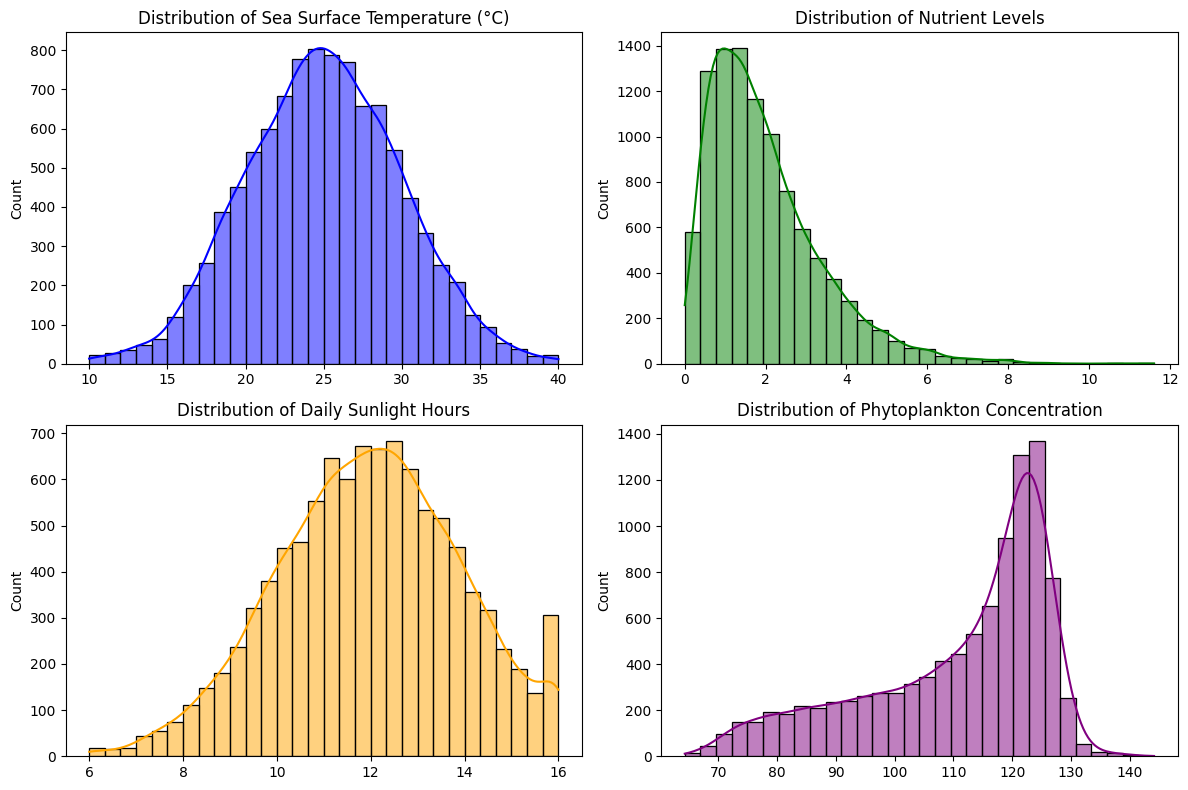

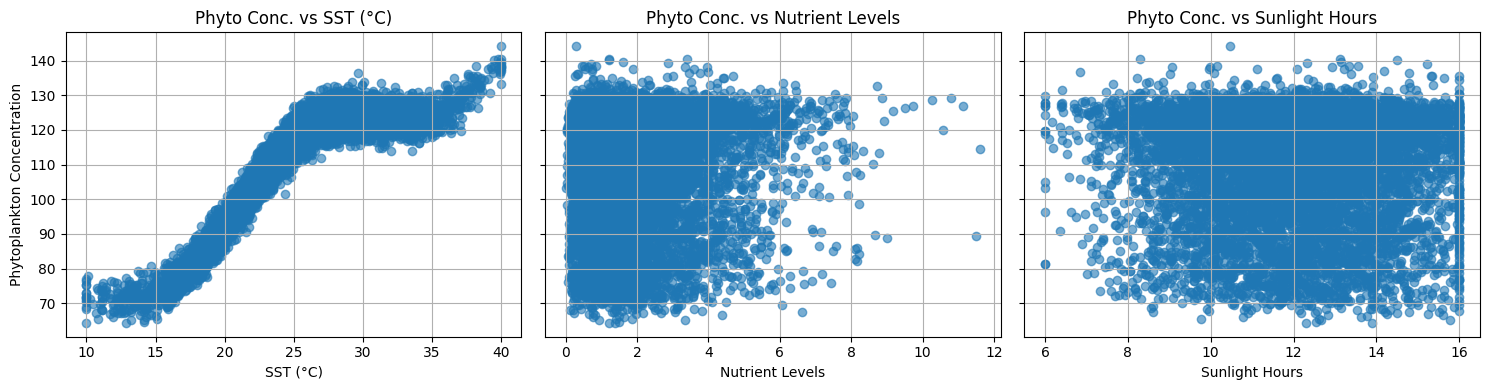

In [3]:
# let's plot the distributions of the data we generated. always do this!!

# set up the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# plot the distributions
sns.histplot(sst, bins=30, kde=True, ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Distribution of Sea Surface Temperature (°C)")

sns.histplot(nutrient_levels, bins=30, kde=True, ax=axes[0, 1], color="green")
axes[0, 1].set_title("Distribution of Nutrient Levels")

sns.histplot(sunlight_hours, bins=30, kde=True, ax=axes[1, 0], color="orange")
axes[1, 0].set_title("Distribution of Daily Sunlight Hours")

sns.histplot(phyto_concentration, bins=30, kde=True, ax=axes[1, 1], color="purple")
axes[1, 1].set_title("Distribution of Phytoplankton Concentration")

# adjust layout
plt.tight_layout()
plt.show()

feature_names = ['SST (°C)', 'Nutrient Levels', 'Sunlight Hours']
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i in range(X.shape[1]):
    axes[i].scatter(X[:, i], y, alpha=0.6)
    axes[i].set_xlabel(feature_names[i])
    axes[i].set_title(f'Phyto Conc. vs {feature_names[i]}')
    axes[i].grid(True)

axes[0].set_ylabel('Phytoplankton Concentration')
plt.tight_layout()
plt.show()

## REMEMBER TO SPLIT YOUR DATA (why? think about it)

In [4]:
# split into training and testing sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Here we do the data preprocessing. This is where you would deal with empty data entries with imputation (imputation = replacing missing values).

Read about imputation:

https://scikit-learn.org/stable/modules/impute.html

You also scale the data.

Read about scaling:

https://scikit-learn.org/stable/modules/preprocessing.html

And when you use a PyTorch neural network, you must convert your NumPy arrays into PyTorch tensors. These are just yet another different type of data type. For one these are called tensors, but they aren't actually tensors like the ones we talk about in differential geometry or general relativity. Similar to now NumPy arrays are an extension of Python lists to make computations more efficient, PyTorch tensors are an extension of NumPy arrays to make computations with neural networks more efficient.


In [5]:
# DATA PREPROCESSING

# # standardize features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# convert to pytorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

Now we will define our neural network. I strongly encourage you to play around with adding more layers and using different activation functions!

In [13]:
# define a deep neural network
# class PhytoplanktonNN(nn.Module):
#     def __init__(self):
#         super(PhytoplanktonNN, self).__init__()
#         self.fc1 = nn.Linear(3, 30)  # input: 3 features → 16 neurons
#         self.fc2 = nn.Linear(30, 15) # hidden layer
#         self.fc3 = nn.Linear(15, 1)  # output: 1 neuron for regression
#         self.relu = nn.ReLU()  # activation function

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# class PhytoplanktonNN(nn.Module):
#     def __init__(self):
#         super(PhytoplanktonNN, self).__init__()
#         # Input: 3 features → first hidden layer: 64 neurons
#         self.fc1 = nn.Linear(3, 64)
#         # Second hidden layer: 32 neurons
#         self.fc2 = nn.Linear(64, 32)
#         # Third hidden layer: 16 neurons
#         self.fc3 = nn.Linear(32, 16)
#         # Output layer: 1 neuron for regression
#         self.fc4 = nn.Linear(16, 1)
#         # ReLU activation function
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         # Forward pass through the network with ReLU activations
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.fc4(x)  # No activation for output
#         return x

class PhytoplanktonNN(nn.Module):
    def __init__(self):
        super(PhytoplanktonNN, self).__init__()
        # Increase the number of layers and neurons to increase complexity
        self.fc1 = nn.Linear(3, 128)   # input: 3 features -> 128 neurons (larger size)
        self.fc2 = nn.Linear(128, 64)  # hidden layer 2
        self.fc3 = nn.Linear(64, 32)   # hidden layer 3
        self.fc4 = nn.Linear(32, 16)   # hidden layer 4
        self.fc5 = nn.Linear(16, 8)    # hidden layer 5
        self.fc6 = nn.Linear(8, 1)     # output layer: 1 neuron for regression
        self.relu = nn.ReLU()  # activation function
        self.dropout = nn.Dropout(0.3)  # Dropout with a 30% probability

    def forward(self, x):
        x = self.relu(self.fc1(x))  # apply ReLU activation to layer 1
        # x = self.dropout(x)  # apply dropout after the first layer
        x = self.relu(self.fc2(x))  # apply ReLU activation to layer 2
        # x = self.dropout(x)  # apply dropout after the first layer
        x = self.relu(self.fc3(x))  # apply ReLU activation to layer 3
        # x = self.dropout(x)  # apply dropout after the first layer
        x = self.relu(self.fc4(x))  # apply ReLU activation to layer 4
        x = self.relu(self.fc5(x))  # apply ReLU activation to layer 5
        x = self.fc6(x)             # output layer (no activation function here)
        return x
    

# class PhytoplanktonNN(nn.Module):
#     def __init__(self):
#         super(PhytoplanktonNN, self).__init__()
#         # Increase the number of layers and neurons to increase complexity
#         self.fc1 = nn.Linear(3, 128)   # input: 3 features → 128 neurons (larger size)
#         self.fc2 = nn.Linear(128, 64)  # hidden layer 2
#         self.fc3 = nn.Linear(64, 32)   # hidden layer 3
#         self.fc4 = nn.Linear(32, 16)   # hidden layer 4
#         self.fc5 = nn.Linear(16, 8)    # hidden layer 5
#         self.fc6 = nn.Linear(8, 1)     # output layer: 1 neuron for regression

#         self.relu = nn.ReLU()  # activation function
#         self.dropout = nn.Dropout(0.3)  # Dropout with a 30% probability
#         self.batch_norm1 = nn.BatchNorm1d(128)  # Batch Normalization for the first hidden layer
#         self.batch_norm2 = nn.BatchNorm1d(64)   # Batch Normalization for the second hidden layer
#         self.batch_norm3 = nn.BatchNorm1d(32)   # Batch Normalization for the third hidden layer
#         self.batch_norm4 = nn.BatchNorm1d(16)   # Batch Normalization for the fourth hidden layer
#         self.batch_norm5 = nn.BatchNorm1d(8)    # Batch Normalization for the fifth hidden layer

#     def forward(self, x):
#         x = self.relu(self.batch_norm1(self.fc1(x)))  # apply BatchNorm + ReLU activation to layer 1
#         x = self.dropout(x)  # apply dropout after the first layer
#         x = self.relu(self.batch_norm2(self.fc2(x)))  # apply BatchNorm + ReLU activation to layer 2
#         x = self.dropout(x)  # apply dropout after the second layer
#         # x = self.relu(self.batch_norm3(self.fc3(x)))  # apply BatchNorm + ReLU activation to layer 3
#         x = self.dropout(x)  # apply dropout after the third layer
#         # x = self.relu(self.batch_norm4(self.fc4(x)))  # apply BatchNorm + ReLU activation to layer 4
#         # x = self.dropout(x)  # apply dropout after the fourth layer
#         # x = self.relu(self.batch_norm5(self.fc5(x)))  # apply BatchNorm + ReLU activation to layer 5
#         x = self.fc6(x)             # output layer (no activation function here)
#         return x

Now we will use our model and define our criterion and optimizer.

Read about these things in the PyTorch docs:

https://pytorch.org/docs/stable/nn.html

In [14]:
# instantiate model, define loss function and optimizer
model = PhytoplanktonNN()
criterion = nn.MSELoss()  # mean squared error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

Now set up the training loop to train over n epochs

In [15]:
# training loop
epochs = 1000
losses = []  # store training losses
losses_val = []  # store validation losses

for epoch in range(epochs):
    ### TRAINING PHASE ###
    model.train() # set the model to training mode
    optimizer.zero_grad() # gradients need to be set to zero so that they are not accumulated from the previous iteration
    
    # forward pass on training data
    y_train_calc = model(X_train_tensor)

    # measure loss for training data
    loss_train = criterion(y_train_calc, y_train_tensor) # this is the tensor that tracks gradients
    losses.append(loss_train.item()) # keep track of training losses

    # back pass (aka backpropagation), update weights
    loss_train.backward()
    optimizer.step()

    ### VALIDATION PHASE ###
    model.eval() # set the model to evaluation mode
    with torch.no_grad(): # disable gradient calculation during validation
        y_val_calc = model(X_val_tensor)
        loss_val = criterion(y_val_calc,y_val_tensor) # calculate validation loss

    losses_val.append(loss_val.item()) # store validation loss
    
    if (epoch) % 50 == 0 or epoch == (epochs - 1):  # print loss every 50 epochs
        print(f"Epoch {epoch:4d} | Training Loss: {loss_train.item():.4f} | Validation Loss: {loss_val.item():.4f}")
        # print(f"epoch {epoch+1}/{epochs}, loss: {loss.item():.4f}")
        # print(f"Epoch {i:4d} | Training Loss: {loss_train.item():.4f} | Validation Loss: {loss_val.item():.4f} | log Learning Rate: {np.log10(current_lr):.4f}")

Epoch    0 | Training Loss: 12451.4336 | Validation Loss: 12429.4111
Epoch   50 | Training Loss: 11956.4629 | Validation Loss: 11893.8398
Epoch  100 | Training Loss: 1207.4084 | Validation Loss: 1179.6116
Epoch  150 | Training Loss: 763.0966 | Validation Loss: 767.6509
Epoch  200 | Training Loss: 521.7283 | Validation Loss: 524.8314
Epoch  250 | Training Loss: 338.5281 | Validation Loss: 338.9069
Epoch  300 | Training Loss: 209.8353 | Validation Loss: 209.3510
Epoch  350 | Training Loss: 126.5526 | Validation Loss: 126.1045
Epoch  400 | Training Loss: 76.4469 | Validation Loss: 76.1486
Epoch  450 | Training Loss: 48.3406 | Validation Loss: 48.1659
Epoch  500 | Training Loss: 33.6447 | Validation Loss: 33.5076
Epoch  550 | Training Loss: 26.2623 | Validation Loss: 26.1201
Epoch  600 | Training Loss: 22.4516 | Validation Loss: 22.3050
Epoch  650 | Training Loss: 20.3059 | Validation Loss: 20.1920
Epoch  700 | Training Loss: 18.9190 | Validation Loss: 18.8642
Epoch  750 | Training Loss: 1

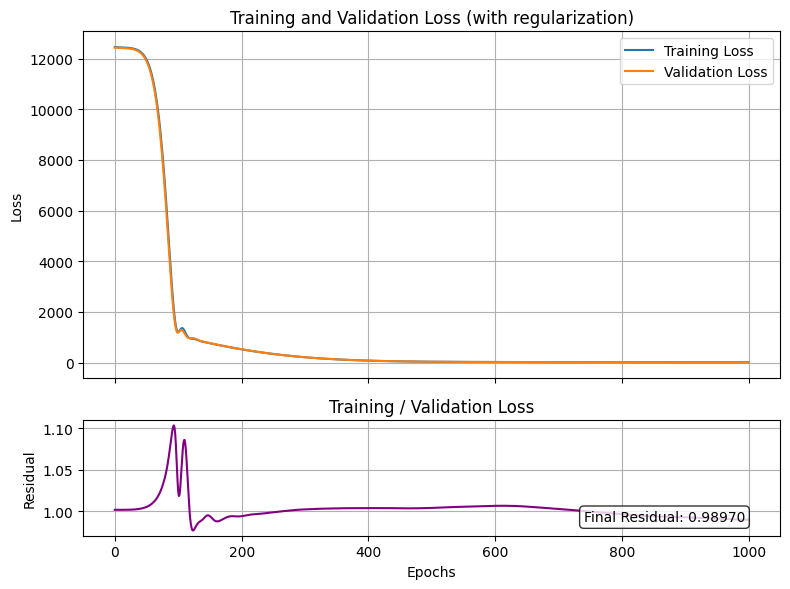

In [16]:
### LOSS CURVES ###
# epochs = 50
# plot training and validation loss over epochs

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(8, 6), 
    gridspec_kw={'height_ratios': [3, 1]},  # 75% top, 25% bottom
    sharex=True  # share the x-axis (epochs)
)

# Plot training and validation loss
ax1.plot(range(len(losses)), losses, label='Training Loss')
ax1.plot(range(len(losses_val)), losses_val, label='Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss (with regularization)')
ax1.legend()
ax1.grid(True)

# Plot residuals (training loss / validation loss)
residuals = [train / val if val != 0 else float('nan') for train, val in zip(losses, losses_val)]
ax2.plot(range(len(losses)), residuals, color='purple')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Residual')
ax2.set_title('Training / Validation Loss')
ax2.grid(True)

# Add text box with final residual value
final_residual = residuals[-1]
textstr = f'Final Residual: {final_residual:.5f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax2.text(0.95, 0.1, textstr, transform=ax2.transAxes, fontsize=10, bbox=props,
          ha='right', va='bottom')

plt.tight_layout()
plt.show()

Now do the model evaluation. Keep a close eye on when we use the training or testing values!

predicting 2000 samples


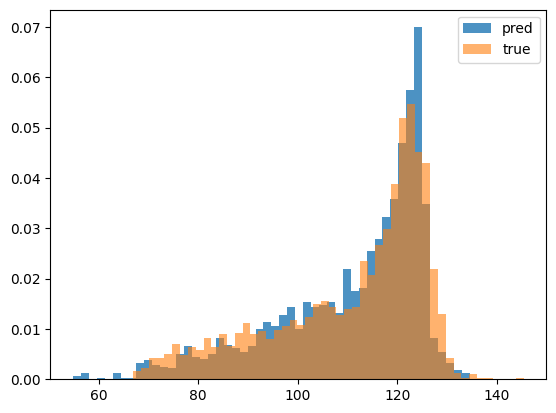

In [17]:
# X_test,y_test,nutrient_levels_,sunlight_hours_,phyto_concentration_ = generate_data(200)

np.random.seed(2025)
num_test_samples = int(0.2*num_samples)
print(f'predicting {num_test_samples} samples')
X_test,y_test,sst_test,nutrient_levels_test,sunlight_hours_test,phyto_concentration_test = generate_data(num_test_samples)

X_test = scaler.transform(X_test) # apply the datapreprocessing
X_test_tensor = torch.tensor(X_test, dtype=torch.float32) # convert to tensor

# model evaluation
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor).numpy()
    # test_predictions = model(X_train_tensor).numpy()

# calculate evaluation metrics
test_mse = mean_squared_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

plt.figure()
plt.hist(test_predictions,bins = 50,alpha = 0.8,density = True, label = 'pred')
plt.hist(phyto_concentration_test,bins = 50,alpha = 0.6,density = True, label = 'true')
plt.legend()
plt.show()

Now we visualize our results and look at the performance metrics.

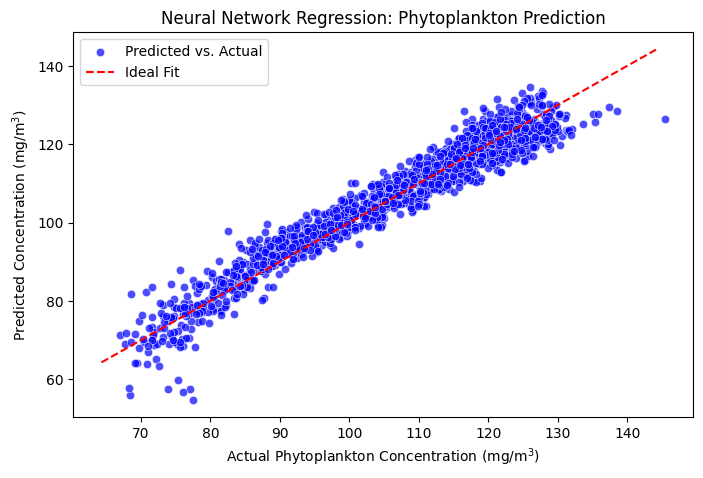

test mse: 13.56
test r^2 score: 0.94


In [18]:
# visualization
plt.figure(figsize=(8, 5))
# sns.scatterplot(x=y_test.flatten(), y=test_predictions.flatten(), label="Predicted vs. Actual", color="blue", alpha=0.7)
sns.scatterplot(x=y_test.flatten(), y=test_predictions.flatten(), label="Predicted vs. Actual", color="blue", alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--", label="Ideal Fit")
plt.xlabel(r"Actual Phytoplankton Concentration (mg/m$^3$)")
plt.ylabel(r"Predicted Concentration (mg/m$^3$)")
plt.title("Neural Network Regression: Phytoplankton Prediction")
plt.legend()
plt.show()

# print evaluation metrics
print(f"test mse: {test_mse:.2f}")
print(f"test r^2 score: {test_r2:.2f}")

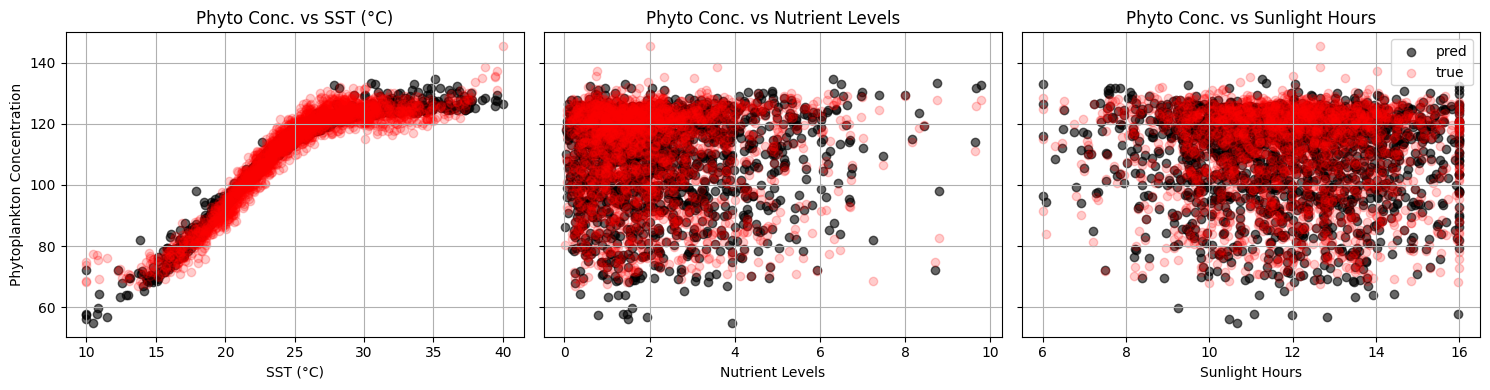

In [19]:
feature_names = ['SST (°C)', 'Nutrient Levels', 'Sunlight Hours']
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# X_test_plot = X_test
X_test_plot = scaler.inverse_transform(X_test)

for i in range(X.shape[1]):
    axes[i].scatter(X_test_plot[:, i], test_predictions, alpha=0.6, c = 'k',label = 'pred')
    axes[i].scatter(X_test_plot[:, i], y_test, alpha=0.2,c = 'r', label = 'true')
    axes[i].set_xlabel(feature_names[i])
    axes[i].set_title(f'Phyto Conc. vs {feature_names[i]}')
    axes[i].grid(True)

axes[0].set_ylabel('Phytoplankton Concentration')
plt.tight_layout()
plt.legend()
plt.show()